# P&D ISSP - Base notebook
@Students: You are free to edit anything you want.

Packages

In [1]:
import os
import matplotlib
import package.general as genfcns
import package.gui_utils as guifcns
matplotlib.style.use('default')  # <-- for notebooks: white figures background

# Root path (path to where you are storing this very notebook)
ROOTPATH = 'F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main'  #  /!/  Adapt this to your system  /!/ 
pathToSoundFiles = f'{ROOTPATH}/sound_files/'

# Parameters (examples)
speechfilenames = [
    pathToSoundFiles + 'speech1.wav',
    pathToSoundFiles + 'speech2.wav'
]
noisefilenames = [
    pathToSoundFiles + 'Babble_noise1.wav'
]
signalDuration = 10     # [s]

Build acoustic scenario and generate RIRs using GUI

In [8]:
# Launch GUI
guifcns.RIRg_GUI(
    exportFolder=f'{os.getcwd()}/rirs',
    outputRIRplot=False,
    distBwMics=10,  # [cm]
    fs=44100,
    t60=0,
    theme='SystemDefault',
)

[INVALID VALUE] Please enter a room dimension larger than 2 metres.
Note that the RIRs are sampled at 44100 Hz.
PyRoomAcoustics is computing the 10 RIRs...
RIRs computed successfully. Saving as Pickle archive.
RIRs saved in file: "rirs_20250224_152128.pkl.gz", in folder
"f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\rirs"
You may close the GUI if not needed anymore!


Acoustic scenario object containing the RIRs, with parameters:
>> Field "audioCoords": [[np.float64(5.05), np.float64(9.05)], [np.float64(5.05), np.float64(1.0)]]
>> Field "audioIds": ['64', '65']
>> Field "c": 340
>> Field "distBwMics": 0.1
>> Field "exportFolder": f:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main/rirs
>> Field "fs": 44100
>> Field "lineIds": [1, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57]
>> Field "lineTextIds": [2, 5, 7, 9, 11, 13, 15, 17, 19, 21, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58]
>> Field "micCoords": [[np.float64(9.05), np.float64(4.95)], [np.float64(9.05), np.float64(5.05)], [np.float64(9.05), np.float64(5.15)], [np.float64(9.05), np.float64(5.25)], [np.float64(9.05), np.float64(5.3500000000000005)]]
>> Field "micsIds": ['59', '60', '61', '62', '63']
>> Field "nMicsPerArray": 5
>> Field "noiseCoords": []
>> Field "noiseIds": []
>> Field "numMics": 5
>>

RIRs selection

(22050, 5, 2)


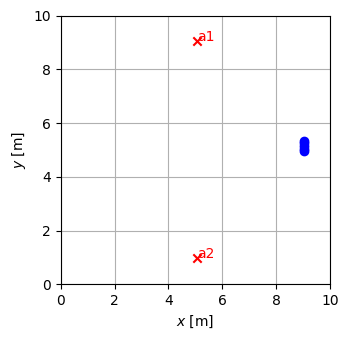

<Figure size 640x480 with 0 Axes>

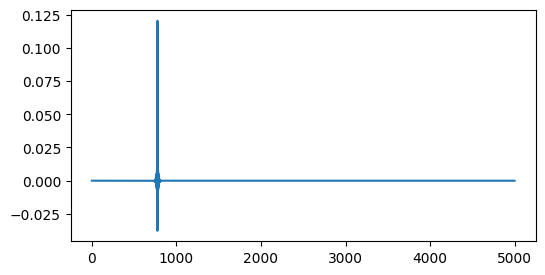

In [9]:
import matplotlib.pyplot as plt
# Select RIRs to be used
# rirFile = 'rirs/'  # use this to input a specific set of RIRs (full path to .pkl.gz file)
rirFile = genfcns.select_latest_rir(path='./rirs/')  # use this to select the lastly generated RIRs
# Load from Pickle archive
acousticScenario = guifcns.load_rirs(path=rirFile)
# >>> NB: the RIRs can be accessed as acousticScenario.RIRsAudio /or/ RIRsNoise
acousticScenario.plot_asc()  # show the acoustic scenario as a pl

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(acousticScenario.RIRsAudio[0:5000,0,0])

# plt.figure()
# plt.figure(figsize=(6, 3))
# plt.plot(acousticScenario.RIRsNoise[:,0,0])
print(acousticScenario.RIRsAudio.shape)
# print(acousticScenario)

# print(acousticScenario.RIRsAudio)
# print(acousticScenario.RIRsNoise.shape)
# print(acousticScenario)


(441000, 5)


<Figure size 640x480 with 0 Axes>

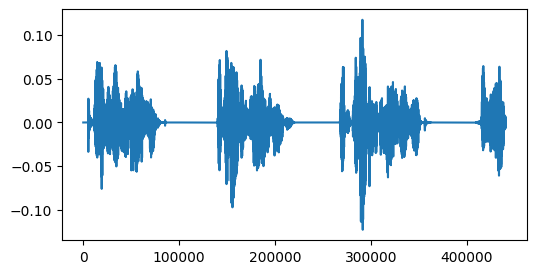

<Figure size 640x480 with 0 Axes>

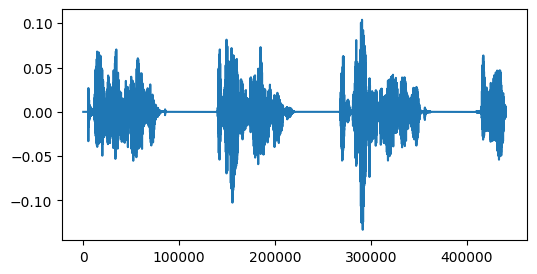

In [10]:
# Part 2
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(audio_name1, audio_name2, noise_name, acousticScenario):
    num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
    num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
    if acousticScenario.RIRsNoise is None:
        num_noise = 0   # number of noise sources
    else:
        num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        RIR_noise1 = acousticScenario.RIRsNoise.squeeze(axis=2)  
      
    fs = acousticScenario.fs    # unit: Hz
    T_ds = int(10*fs)  # unit: s

    if num_audio == 2:
        RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
        RIR_audio1 = RIR_audio1.squeeze(axis=2)
        RIR_audio2 = RIR_audio2.squeeze(axis=2)
    else:
        RIR_audio1 = acousticScenario.RIRsAudio.squeeze(axis=2)
    
    speech1, sr_speech1 = sf.read(audio_name1)
    speech2, sr_speech2 = sf.read(audio_name2)
    noise1, sr_noise1 = sf.read(noise_name)

    num_samples_speech1 = int(len(speech1) * fs / sr_speech1)
    num_samples_speech2 = int(len(speech2) * fs / sr_speech2)
    num_samples_noise = int(len(noise1) * fs / sr_noise1)
    speech1 = signal.resample(speech1, num_samples_speech1)
    speech2 = signal.resample(speech2, num_samples_speech2)
    noise1 = signal.resample(noise1, num_samples_noise)

    speech1 = speech1[0:T_ds]
    speech2 = speech2[0:T_ds]
    noise1 = noise1[0:T_ds]

    mic1 = []
    mic2 = []

    for i in range(num_micro):
        rec_signal1_tmp = scipy.signal.fftconvolve(speech1, RIR_audio1[:,i])
        if num_audio == 2:
            rec_signal2_tmp = scipy.signal.fftconvolve(speech2, RIR_audio2[:,i])
        else:
            rec_signal2_tmp = np.zeros(rec_signal1_tmp.shape)

        if acousticScenario.RIRsNoise is not None:
            rec_noise_tmp = scipy.signal.fftconvolve(noise1, RIR_noise1[:,i])  
            rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp

        mic1.append(rec_signal1_tmp)
        mic2.append(rec_signal2_tmp)

    mic1 = np.array(mic1)
    mic2 = np.array(mic2)

    mic = mic1 + mic2    
    mic = mic.T

    return mic[0:T_ds,:], speech1, speech2, noise1, fs

mic, speech1, speech2, noise1, fs = create_micsigs('F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech1.wav', 'F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\speech2.wav',"F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)

# sd.play(speech1[0:fs*1], fs)
sd.play(mic[:,0], fs)

print(mic.shape)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])


(441000, 4)


<Figure size 640x480 with 0 Axes>

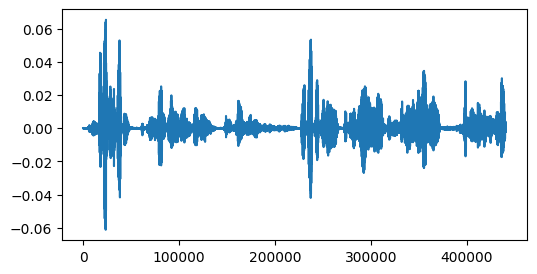

<Figure size 640x480 with 0 Axes>

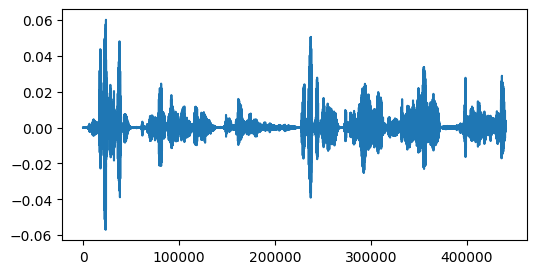

In [299]:
# Part 2 Ruben's version: compatible with arbitrary number of audio sources and noise sources
import scipy
import numpy as np
import soundfile as sf
import scipy.signal as signal
import sounddevice as sd

def create_micsigs(target_audio_files, noise_audio_files, acousticScenario, T_s, hmr_paths):
    
    if len(hmr_paths) == 0:
        num_micro = acousticScenario.RIRsAudio.shape[1]   # number of microphones
        # num_audio = acousticScenario.RIRsAudio.shape[2]   # number of audio sources
        # num_noise = acousticScenario.RIRsNoise.shape[2]   # number of noise sources
        fs = acousticScenario.fs
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)
        
        # Load and resample noise sources
        noise_components = []
        for file in noise_audio_files:
            noise, fs_noise = sf.read(file)
            noise_resampled = signal.resample(noise, int(len(noise) * fs / fs_noise)) if fs != fs_noise else noise
            noise_padded = np.pad(noise_resampled[:T_ds], (0, max(0, T_ds - len(noise_resampled))))
            noise_components.append(noise_padded)

        mic_signals = np.zeros((T_ds, num_micro))
        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = acousticScenario.RIRsAudio[:, mic_idx, audio_idx]
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
            for noise_idx, noise in enumerate(noise_components):
                rir_noise = acousticScenario.RIRsNoise[:, mic_idx, noise_idx]
                mic_signal += signal.fftconvolve(noise, rir_noise, mode='same')

            mic_signals[:, mic_idx] = mic_signal
    else:
        all_paths = []
        for fpath in hmr_paths:
            all_paths.append([fpath + "/HMIR_L1.wav",fpath + "/HMIR_L2.wav",fpath + "/HMIR_R1.wav",fpath + "/HMIR_R2.wav"])
        fs = sf.read(all_paths[0][0])[1]
        T_ds = int(T_s * fs)

        # Load and resample target audio sources
        speech_components = []
        noise_components = []
        for file in target_audio_files:
            speech, fs_audio = sf.read(file)
            speech_resampled = signal.resample(speech, int(len(speech) * fs / fs_audio)) if fs != fs_audio else speech
            speech_padded = np.pad(speech_resampled[:T_ds], (0, max(0, T_ds - len(speech_resampled))))
            speech_components.append(speech_padded)

        num_micro = 4
        mic_signals = np.zeros((T_ds, num_micro))

        for mic_idx in range(num_micro):
            mic_signal = np.zeros(T_ds)
            for audio_idx, speech in enumerate(speech_components):
                rir_speech = sf.read(all_paths[audio_idx][mic_idx])[0]
                rir_speech = rir_speech[0:int(0.005*fs)]
                mic_signal += signal.fftconvolve(speech, rir_speech, mode='same')
        
            mic_signals[:, mic_idx] = mic_signal
            
    # Plot first two microphone signals
    # for mic_idx in range(num_micro):
    #     plt.figure(figsize=(10, 4))
    #     plt.plot(mic_signals[:, mic_idx], label=f'Mic {mic_idx + 1}')
    #     plt.title(f"Microphone {mic_idx + 1} Signal")
    #     # plt.xlim((6425,6470))
    #     plt.xlabel("Samples")
    #     plt.ylabel("Amplitude")
    #     plt.legend()
    #     plt.show()
    
    return mic_signals, speech_components, noise_components, fs


Time_duration = 10
mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track1_dry.wav","F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track2_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-30","F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s60"])
# mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track1_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s-30"])    # single sudio source on left-hand side
# mic, speech, noise, fs = create_micsigs(["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part2_track2_dry.wav"], [], acousticScenario, Time_duration, ["F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"])    # single sudio source on right-hand side
# mic = mic[:,0:2]    # Select L1&L2
# mic = mic[:,2:4]    # Select R1&R2
# mic = mic[:,[0,2]]    # Select L1&R1

# sd.play(speech1[0:fs*1], fs)
# sd.play(mic[:,2], fs)

print(mic.shape)
# Play the first microphone signal
# sd.play(mic[:, 0], samplerate=acousticScenario.fs)
# sd.wait()  # Wait until playback finishes

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,0])

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(mic[:,1])

In [ ]:
#Part 3
import numpy as np
import scipy.signal as signal

def TDOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  rir1 = acousticScenario.RIRsAudio[:,0,0]
  rir2 = acousticScenario.RIRsAudio[:,1,0]

  direct_path_idx1 = np.argmax(np.abs(rir1))
  direct_path_idx2 = np.argmax(np.abs(rir2))

  ground_truth_TDOA = (direct_path_idx1 - direct_path_idx2) / acousticScenario.fs
  print(f"Ground truth TDOA: {ground_truth_TDOA:.6f} seconds")

  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:, 0] # Signal of the first mic
  mic2 = mic_signals[:, 1] # Signal of the second mic

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs
  print(f"Estimated TDOA: {estimated_TDOA:.6f} seconds")

  plt.figure(figsize=(8, 4))
  plt.plot(lags / acousticScenario.fs, cross_corr, label="Crosscorrelation")
  plt.stem([ground_truth_TDOA], [np.max(cross_corr)], linefmt="r-", markerfmt="ro", basefmt="r-", label="Groundtruth")
  plt.stem([estimated_TDOA], [np.max(cross_corr)], linefmt="g-", markerfmt="go", basefmt="g-", label="Estimated value")

  plt.xlabel("Time difference (seconden)")
  plt.ylabel("Crosscorrelation amplitude")
  plt.legend()
  plt.title("TDOA estimate via crosscorrelation")
  plt.xlim(-0.01, 0.01)
  plt.grid()
  plt.show()

  # Step 5: Print de fout tussen de schatting en de grondwaarheid
  error = np.abs(estimated_TDOA - ground_truth_TDOA)
  print(f"TDOA estimation error: {error:.6f} seconds")

TDOA_corr('F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav', 'F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav',"F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)



In [ ]:
#Part 4
def DOA_corr(audio1_name, audio2_name, noise_name, acousticScenario):
  mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

  mic1 = mic_signals[:,0] # First mic signal
  mic2 = mic_signals[:,1] # Second mic signal

  cross_corr = signal.correlate(mic1, mic2, mode="full")
  lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

  cross_corr /= np.max(np.abs(cross_corr))
  peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

  if len(peaks) < 2:
    raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")
  
  peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
  selected_peaks = peaks[peak_indices]

  TDOAestAll = []

  for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

  print(f"First estimated TDOA: {TDOAestAll[0]:.6f} seconds")
  print(f"Second estimated TDOA: {TDOAestAll[1]:.6f} seconds")

  c = 340 # Speed of sound in air (m/s)
  mic_distance = acousticScenario.distBwMics
  TDOAestAll = np.array(TDOAestAll)
  cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
  cos_theta = np.clip(cos_theta, -1, 1)
  DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

  print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")
  print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
  
  plt.figure(figsize=(8, 4))
  plt.plot(lags / fs, cross_corr, label="cross correlation")
  plt.axvline(x=estimated_TDOA, color='g', linestyle="--", label=f"TDOA: {estimated_TDOA:.6f}s")

  plt.xlabel("Time difference (seconds)")
  plt.ylabel("Cross correlation amplitude")
  plt.legend()
  plt.xlim(-0.01,0.01)
  plt.title("TDOA and DOA estimation via crosscorrelation")
  plt.grid()
  plt.show()
  

  DOAestAll = DOA_estimate
  DOAestAll = np.array(DOAestAll)
  return DOAestAll

DOAestALL = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
print(DOAestALL)


In [ ]:
# Part 5
def TDOA_corr_2(audio1_name, audio2_name, noise_name, acousticScenario, mic):
 first_source = 0
 second_source = 1
 rir1_1 = acousticScenario.RIRsAudio[:,first_source,0]
 rir2_1 = acousticScenario.RIRsAudio[:,second_source,0]

 direct_path_idx1_1 = np.argmax(np.abs(rir1_1))
 direct_path_idx2_1 = np.argmax(np.abs(rir2_1))

 ground_truth_TDOA_1 = (direct_path_idx1_1 - direct_path_idx2_1) / acousticScenario.fs

 print(f"Ground truth TDOA of source 1: {ground_truth_TDOA_1:.6f} seconds")

 rir1_2 = acousticScenario.RIRsAudio[:,first_source,1]
 rir2_2 = acousticScenario.RIRsAudio[:,second_source,1]

 direct_path_idx1_2 = np.argmax(np.abs(rir1_2))
 direct_path_idx2_2 = np.argmax(np.abs(rir2_2))

 ground_truth_TDOA_2 = (direct_path_idx1_2 - direct_path_idx2_2) / acousticScenario.fs

 print(f"Ground truth TDOA of source 2: {ground_truth_TDOA_2:.6f} seconds")

 mic_signals, _, _, _, _ = create_micsigs(audio1_name, audio2_name, noise_name, acousticScenario)

 mic1 = mic_signals[:, 0] # Signal of the first mic
 mic2 = mic_signals[:, 1] # Signal of the second mic

 cross_corr = signal.correlate(mic1, mic2, mode="full")
 lags = signal.correlation_lags(len(mic1), len(mic2), mode="full")

 cross_corr /= np.max(np.abs(cross_corr))
 peaks, properties = signal.find_peaks(cross_corr, height=0.2) # Peaks above 50% of max

 if len(peaks) < 2:
  raise ValueError("Less than 2 peaks found. Cannot estimate exactly 2 DOAs.")

 # Select the two highest peaks
 peak_indices = np.argsort(properties["peak_heights"])[-2:] # Get indices of top 2 peaks
 selected_peaks = peaks[peak_indices]

 TDOAestAll = []

 for peak in selected_peaks:
    estimated_TDOA = lags[peak] / acousticScenario.fs
    TDOAestAll.append(estimated_TDOA)

 estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

 print(f"First estimated TDOA: {TDOAestAll[1]:.6f} seconds")
 print(f"Second estimated TDOA: {TDOAestAll[0]:.6f} seconds")

 c = 340 # Speed of sound in air (m/s)
 mic_distance = acousticScenario.distBwMics
 TDOAestAll = np.array(TDOAestAll)
 cos_theta = (TDOAestAll * c) / mic_distance # estimated cosine of the angle
 cos_theta = np.clip(cos_theta, -1, 1)
 DOA_estimate = np.arccos(cos_theta) * (180 / np.pi) # Angle in degrees

 print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")
 print(f"estimated DOA: {DOA_estimate[0]:.2f} degrees")

TDOA_corr_2("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario, mic)


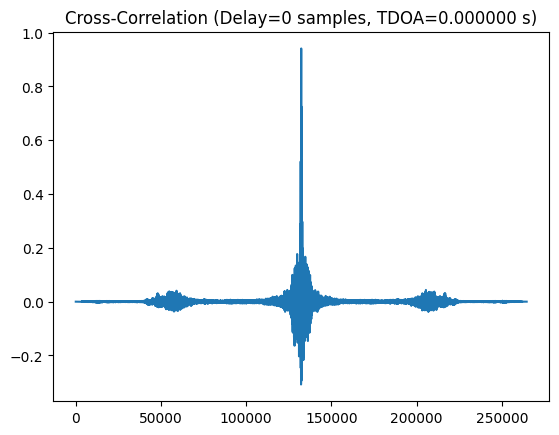

DOA estimate for HMIR_L1.wav & HMIR_L2.wav: 90.00°


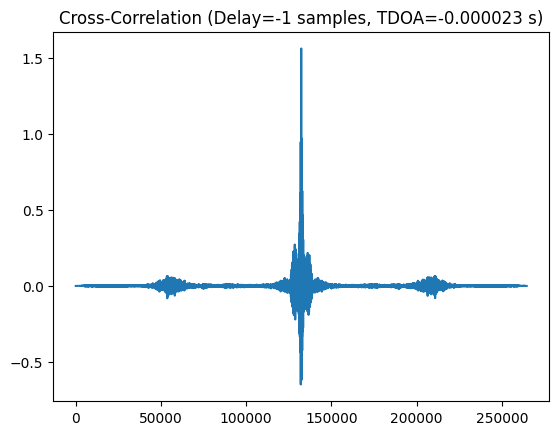

DOA estimate for HMIR_R1.wav & HMIR_R2.wav: 126.37°


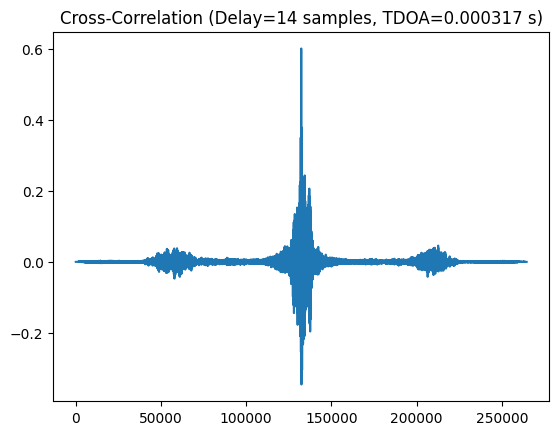

DOA estimate for HMIR_L1.wav & HMIR_R1.wav: 59.87°


In [71]:
# Part 6
import numpy as np
import soundfile as sf
import scipy.signal as sig
import matplotlib.pyplot as plt
import os
import glob

def create_micsigs_2(rir_files, audio_file):
  # """Generates microphone signals from measured impulse responses."""
  rir_signals = [sf.read(f)[0] for f in rir_files]
  audio, fs_audio = sf.read(audio_file)

  # Ensure sampling rates match
  fs_rir = sf.read(rir_files[0])[1]

  T_ds = int(3*fs_rir)
  audio = audio[0:T_ds]

  if fs_audio != fs_rir:
    audio = sig.resample(audio, int(len(audio) * fs_rir / fs_audio))

  # Convolve with impulse response
  mic_signals = [sig.fftconvolve(audio, rir)[:len(audio)] for rir in rir_signals]

  return np.column_stack(mic_signals), fs_rir

def estimate_tdoa(mic1, mic2, fs):
  """Estimates the time difference of arrival (TDOA) using cross-correlation."""
  # corr = sig.correlate(mic1, mic2, mode='full')
  # delay = sig.correlation_lags(len(mic1),len(mic2), mode='full')
  # tdoa = delay[np.argmax(corr)] / fs
  corr = sig.correlate(mic1, mic2, mode='full')
  delay = np.argmax(corr) - (len(mic1) - 1)
  tdoa = delay / fs

  plt.figure()
  plt.plot(corr)
  plt.title(f"Cross-Correlation (Delay={delay} samples, TDOA={tdoa:.6f} s)")
  plt.show()

  return tdoa

def estimate_doa(tdoa, mic_spacing, c=340):
  """Converts TDOA into a DOA estimate."""
  # theta = np.arccos((tdoa * c) / mic_spacing) * (180 / np.pi)
  cos_theta = (tdoa * c) / mic_spacing
  cos_theta = np.clip(cos_theta, -1, 1)
  theta = np.arccos(cos_theta)*(180/np.pi)
  return theta

# Paths to impulse responses and target audio
rir_path = "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30"
audio_file = "F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\part1_track1_dry.wav"
mic_pairs = [("HMIR_L1.wav", "HMIR_L2.wav"), ("HMIR_R1.wav", "HMIR_R2.wav"), ("HMIR_L1.wav", "HMIR_R1.wav")]

# Process each microphone pair
for mic1_file, mic2_file in mic_pairs:
  mic_files = [os.path.join(rir_path, mic1_file), os.path.join(rir_path, mic2_file)]
  mic_signals, fs = create_micsigs_2(mic_files, audio_file)

  # Estimate TDOA
  tdoa = estimate_tdoa(mic_signals[:, 0], mic_signals[:, 1], fs)

  # Define microphone spacing (1.3 cm for same ear, 21.5 cm for opposite ears)
  # mic_spacing = 0.013 if "L1" in mic1_file and "L2" in mic2_file else 0.215
  mic_spacing = 0.215 if "L1" in mic1_file and "R1" in mic2_file else 0.013

  # Estimate DOA
  doa = estimate_doa(tdoa, mic_spacing)
  print(f"DOA estimate for {mic1_file} & {mic2_file}: {doa:.2f}°")





In [78]:
# RIR_audio1, RIR_audio2 = np.dsplit(acousticScenario.RIRsAudio, 2)
# RIR_audio1 = RIR_audio1.squeeze(axis=2)
# RIR_audio2 = RIR_audio2.squeeze(axis=2)
# RIR1_audio1, RIR2_audio1, RIR3_audio1 = np.hsplit(RIR_audio1, 3)
# RIR1_audio = acousticScenario.RIRsAudio[:,0,0]
# RIR1_audio = RIR_audio1[:,0]
# print(RIR1_audio.shape)

    # rec_speech1 = scipy.signal.fftconvolve(speech1, RIR1_audio1)
    # rec_speech2 = scipy.signal.fftconvolve(speech1, RIR2_audio1)
    # rec_speech3 = scipy.signal.fftconvolve(speech1, RIR3_audio1)

# rec_noise1 = scipy.signal.fftconvolve(noise1, RIR1_noise)
# rec_noise2 = scipy.signal.fftconvolve(noise1, RIR2_noise)
# rec_noise3 = scipy.signal.fftconvolve(noise1, RIR3_noise)

# rec_speech1 = rec_speech1 + rec_noise1[0:len(rec_speech1)]
# rec_speech2 = rec_speech2 + rec_noise2[0:len(rec_speech2)]
# rec_speech3 = rec_speech3 + rec_noise3[0:len(rec_speech3)]

# mic = np.column_stack((rec_speech1, rec_speech2, rec_speech3))

    # RIR_noise1 = np.dsplit(acousticScenario.RIRsNoise, 2)
    # RIR_noise1 = RIR_audio1.squeeze(axis=2)

    # RIR1_audio1, RIR2_audio1, RIR3_audio1 = np.hsplit(RIR_audio1, 3)

    # RIR1_noise = acousticScenario.RIRsNoise[:,0,0]
    # RIR2_noise = acousticScenario.RIRsNoise[:,1,0]
    # RIR3_noise = acousticScenario.RIRsNoise[:,2,0]

    # max_cols = max(mic1.shape[1], mic2.shape[1])
    # mic1_padded = np.pad(mic1, ((0, 0), (0, max_cols - mic1.shape[1])), mode='constant')
    # mic2_padded = np.pad(mic2, ((0, 0), (0, max_cols - mic2.shape[1])), mode='constant')

    # mic = np.vstack((mic1_padded,mic2_padded))
    # mic = mic1_padded + mic2_padded

# rec_signal1_tmp = rec_signal1_tmp + rec_noise_tmp[0:len(rec_signal1_tmp)]  #may have problems if length of noise is shorter than the signals!

  # estimated_TDOA = lags[np.argmax(cross_corr)] / acousticScenario.fs

  # fs = acousticScenario.fs # Sampling frequentie uit RIR GUI
  # estimated_TDOA = lags[np.argmax(cross_corr)] / fs # TDOA in seconds

  # print(f"estimated TDOA: {estimated_TDOA:.6f} seconds")

  # cos_theta = (estimated_TDOA * c) / mic_distance # estimated cosine of the angle

  # DOA_estimate = 90 - DOA_estimate # 90° is broadside, 180° is end-fire

# print(f"estimated DOA: {DOA_estimate[1]:.2f} degrees")

# mic_part6, fs_part6= create_micsigs_2(rir_path, audio_file)

# print(mic_part6.shape)
# sd.play(mic_signals[:,0], fs)

  # if os.path.isdir(rir_path):
  #       rir_files = glob.glob(os.path.join(rir_path, "*.wav"))  # 默认寻找 WAV 文件
  #       if len(rir_files) == 0:
  #           raise ValueError(f"No RIR files found in {rir_path}")
  # else:
  #       rir_files = rir_path  # 如果已经是列表，则直接使用

  # # 读取所有 RIR 文件
  # rir_signals = [sf.read(f)[0] for f in rir_files]

#  rir1_1 = acousticScenario.RIRsAudio[:,0,0]
#  rir2_2 = acousticScenario.RIRsAudio[:,1,0]

#  rir1_2 = acousticScenario.RIRsAudio[:,0,1]
#  rir2_2 = acousticScenario.RIRsAudio[:,1,1]

#  mic1 = mic_signals[:, mic[0]] # Signal of the first mic
#  mic2 = mic_signals[:, mic[1]] # Signal of the second mic

# Zxx 形状一般为 (nF, nT)，其中 nF = L/2+1（对真实信号 return_onesided=True 时）

    """
    参数:
    --------
    stft_mics : ndarray, shape (M, nF, nT)
        M 个麦克风的 STFT 结果:
          - M: 麦克风数量
          - nF: 频率 bin 个数
          - nT: 时间帧数
    fs : float
        采样率 (Hz)。
    Q : int
        目标声源数量 (已知)。
    d : float
        相邻麦克风阵元间距 (m)。
    c : float
        声速 (m/s)。
        
    返回:
    --------
    doa_estimates : ndarray, shape (Q,)
        估计的 Q 个 DOA (单位: °)，可能无序，可自行排序。
    """

 # -------------------------------------------------------------------------
    # 1) 找到能量最大的频点（与单源版本相同）
    # -------------------------------------------------------------------------

    # 若出现 DC bin 功率过大，可手动置零以避免其干扰

    # 也可以使用 stft 返回的真实频率数组 f 来取 f_bin = f[fidx]
    # 这里演示一个近似公式:
    # f_bin = (fidx / (nF - 1)) * (fs / 2)

# -------------------------------------------------------------------------
    # 2) 提取该频点在所有麦克风、所有时间帧的数据 => 用于计算空间协方差 Rxx
    # -------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # 3) 特征分解，区分 (Q) 信号子空间和 (M - Q) 噪声子空间
    # -------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # 4) 遍历角度 θ=0°~180°, 步进 0.5°, 计算 MUSIC 伪谱
    #    P(θ) = 1 / ( a^H(θ)*Un*Un^H*a(θ) )
    # -------------------------------------------------------------------------

        # 若 0° 定义在端火方向(沿阵列)，应使用 cos(θ)
        # 若 0° 定义在broadside(垂直阵列), 则使用 sin(θ)
        # 题目倾向 "0°=top end-fire", 故用 cos(θ):

    # -------------------------------------------------------------------------
    # 5) 在伪谱中寻找 Q 个最大的峰，对应 Q 个声源方位
    # -------------------------------------------------------------------------
    # 简单方式: 直接取 P_music 最大的 Q 个点(可能需要去重/不相邻)

    # -------------------------------------------------------------------------
    # 6) 可视化：绘制 pseudospectrum，并标记 Q 个峰
    # -------------------------------------------------------------------------

    # -------------------------------------------------------------------------
    # 3) 计算几何平均的宽带伪谱:
    #       p̄(θ) = [∏ p_k(θ)]^(1 / nFreqUsed)
    #   为避免数值下溢, 用 log 域处理:
    #       log p̄(θ) = (1/nFreqUsed) * Σ(log p_k(θ))
    # -------------------------------------------------------------------------

LibsndfileError: Error opening 'F': System error.

# Signal processing - Week 2: MUSIC algorithm

Computing DOAs via freq.-domain MUSIC algorithm...


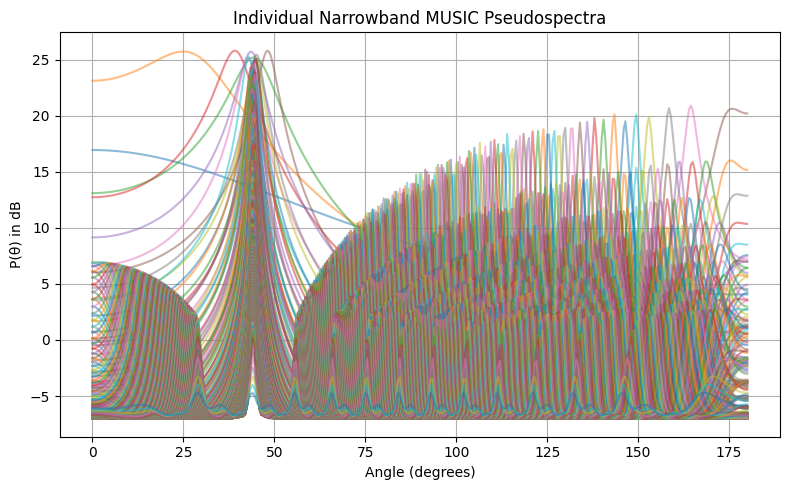

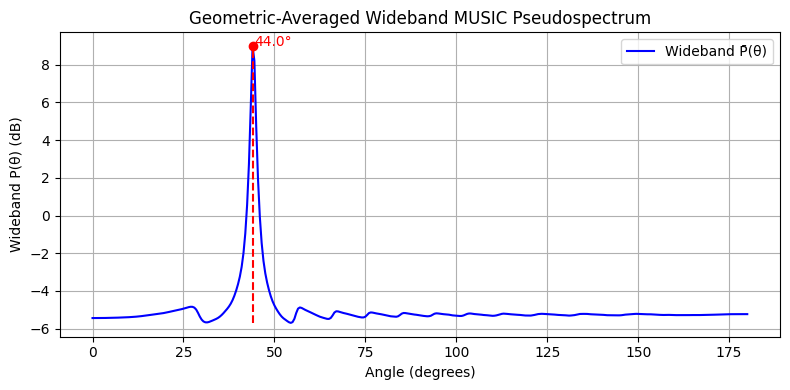

All estimated DOAs: [2521.01429858]
Selected estimated DOAs: [2521.01]
Ground truth DOAs: [43.61]
Estimate error(s): [0.39] deg.
[44.]


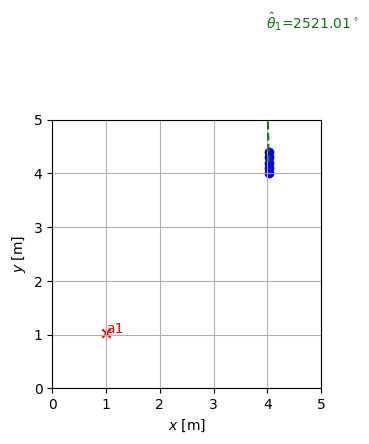

In [36]:
import numpy as np

winLength = 1024 # Window length
# nSources = acousticScenario.RIRsAudio.shape[-1] +\
#     acousticScenario.RIRsNoise.shape[-1] # Number of sources
theta = np.arange(0, np.pi, step=np.pi / 360)  # angles to consider

print('Computing DOAs via freq.-domain MUSIC algorithm...')

# DOAestAll = DOA_corr("F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_1.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\whitenoise_signal_2.wav", "F:\KU Leuven\courses\P&D ISSP\project\panddissp-base-main\sound_files\Babble_noise1.wav", acousticScenario)
# DOAestAll = music_narrowband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
DOAestAll = music_wideband(stft_mics, acousticScenario.fs, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# DOAestAll = np.zeros(nSources)  # default

print(f'All estimated DOAs: {DOAestAll * 180 / np.pi}')

# ------------------ DOA estimation performance check ------------------
# Automatic selection of the target DOA
DOAest, groundTruthDOAtalkers = genfcns.auto_choice_doa(
    DOAestAll, acousticScenario
)
print(f'Selected estimated DOAs: {np.round(DOAest * 180 / np.pi, 2)}')
print(f'Ground truth DOAs: {np.round(groundTruthDOAtalkers * 180 / np.pi, 2)}')
# Check validity
genfcns.check_plot_tdoas(DOAest, DOAestAll, acousticScenario)
# print(f'Estimate error(s): {np.round((DOAest - groundTruthDOAtalkers) * 180/np.pi, 2)} deg.')
print(f'Estimate error(s): {DOAestAll - np.round(groundTruthDOAtalkers * 180 / np.pi, 2)} deg.')
print(DOAestAll)

In [11]:
#frequency check
if acousticScenario.fs == 44100:
    print("Correct sampling frequency: 44.1 kHz")
else:
    raise ValueError(f"False: Incorrect sampling frequency, current sampling frequency {acousticScenario.fs} Hz")

Correct sampling frequency: 44.1 kHz


In [16]:
# STFT
import numpy as np
from scipy.signal import stft

# parameters
fs = 44100         # sampling frequency
L = 1024           # window length
hop = L // 2       # 50% overlap
M = mic.shape[1]   # number of microphones
# n_samples = mic.shape[0]  # number of samples

stft_mics_list = []

for m in range(M):
    mic_signal = mic[:, m]
    
    f, t, Zxx = stft(mic_signal,
                     fs=fs,
                     window='hann',   # 'hann', 'boxcar'
                     nperseg=L,
                     noverlap=hop,
                     return_onesided=True)

    stft_mics_list.append(Zxx)  # shape: (nF, nT)

stft_mics = np.array(stft_mics_list)  # (M, nF, nT)

print("stft_mics shape:", stft_mics.shape)

stft_mics shape: (5, 513, 863)


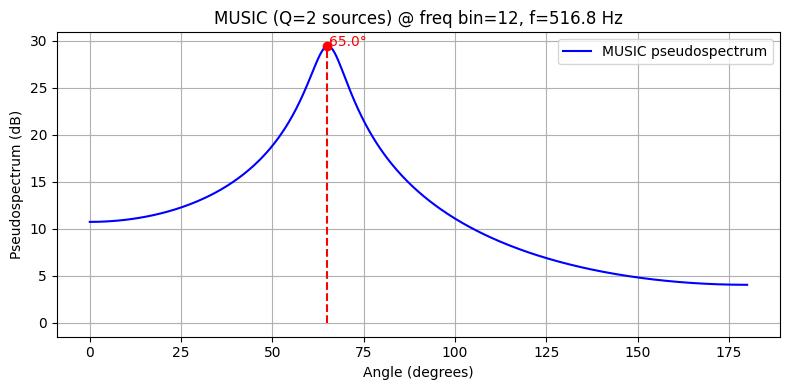

In [303]:
# narrowband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_narrowband(stft_mics, Q, d, c):   
    M, _, nT = stft_mics.shape
    
    power_per_bin = np.mean(np.abs(stft_mics)**2, axis=(0, 2))  # shape: (nF,)
    # power_per_bin[0] = 0  # Avoid DC bin
    
    fidx = np.argmax(power_per_bin) 
    
    f_bin = f[fidx]
    
    X_omega = stft_mics[:, fidx, :]  # shape: (M, nT)
    Rxx = (X_omega @ X_omega.conj().T) / nT  # (M, M)
    
    eigenvals, eigenvecs = np.linalg.eig(Rxx)
    sort_idx = np.argsort(eigenvals)       
    # eigenvals_sorted = eigenvals[sort_idx]
    eigenvecs_sorted = eigenvecs[:, sort_idx]
    
    Un = eigenvecs_sorted[:, :M - Q]  # shape (M, M-Q)  

    theta_vals = np.arange(0, 180.5, 0.5)
    k0 = 2 * np.pi * f_bin / c  # wave number
    P_music = []
    
    m_index = np.arange(M)  # microphone index
    
    for theta_deg in theta_vals:
        theta_rad = np.deg2rad(theta_deg)
        steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # (M,)
        
        v = Un.conj().T @ steer  # shape = (M-Q,)
        denom = np.abs(v @ v.conj())
        pseudospec = 1.0 / denom
        P_music.append(pseudospec)
        
    P_music = np.array(P_music)  # shape (len(theta_vals),)
    
    # peak_indices = np.argsort(P_music)[-Q:]   # 取倒数Q个(最大的Q个)
    # peak_indices = peak_indices[::-1]         # 从大到小  
    # doa_estimates = theta_vals[peak_indices]  # 角度 (°)，可能乱序

    peaks, _ = find_peaks(P_music, distance=5, prominence=0.1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_values_all = P_music[peaks]
        if len(peaks) < Q:
            topQ_idx = np.argsort(peak_values_all)[::-1]  
        else:
            topQ_idx = np.argsort(peak_values_all)[-Q:]  

        topQ_idx_sorted = topQ_idx[np.argsort(peak_values_all[topQ_idx])]  
        
        peak_indices = peaks[topQ_idx_sorted]
        doa_estimates = theta_vals[peak_indices]
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(P_music), 'b-', label='MUSIC pseudospectrum')
    
    for idx in peak_indices:
        peak_angle = theta_vals[idx]
        peak_value = 10*np.log10(P_music[idx])
        plt.stem([peak_angle], [peak_value], linefmt='r--', markerfmt='ro', basefmt=" ")
        plt.text(peak_angle+0.5, peak_value, f"{peak_angle:.1f}°", color='red')
    
    plt.title(f"MUSIC (Q={Q} sources) @ freq bin={fidx}, f={f_bin:.1f} Hz")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Pseudospectrum (dB)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

doa_estimates = music_narrowband(stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c=340)
# doa_estimates = music_narrowband(stft_mics, 1, 0.013, 340)


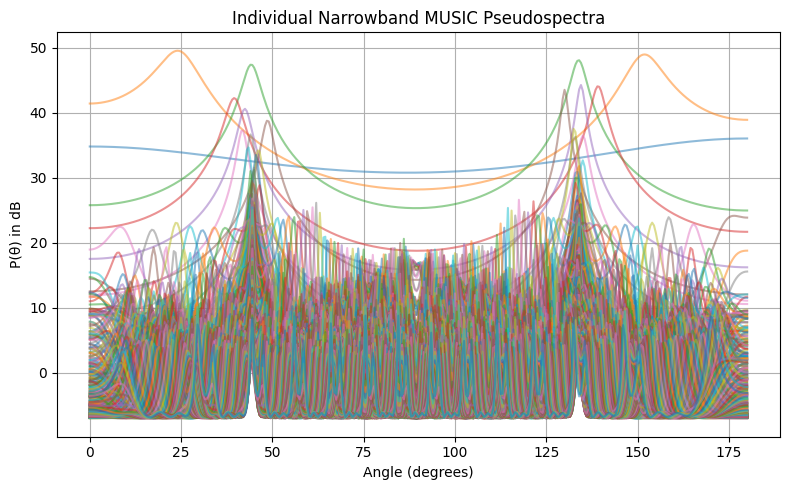

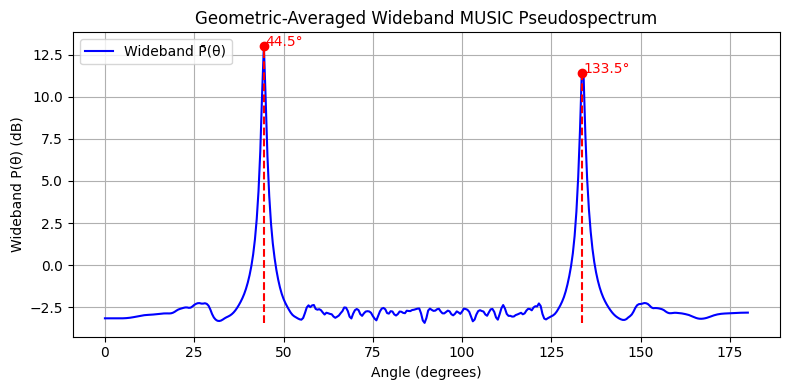

[133.5  44.5]


In [20]:
# wideband
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def music_wideband(stft_mics, Q, d, c):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        k0 = 2.0 * np.pi * f_bin / c
        m_index = np.arange(M)
        
        for j, theta_deg in enumerate(theta_vals):
            theta_rad = np.deg2rad(theta_deg)
            steer = np.exp(-1j * k0 * m_index * d * np.cos(theta_rad))  # can be sin
            
            v = Un.conj().T @ steer
            denom = np.abs(v @ v.conj())
            pseudospec = 1.0 / denom
            
            all_pseudospec[i, j] = pseudospec
    
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    

    log_all = np.log(all_pseudospec + 1e-15)  # Avoid log(0)
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)

    if Q==1:
        peaks = np.argmax(p_wideband)
        peaks = np.array([peaks])
    else:
        peaks, properties = find_peaks(
            p_wideband,
            distance=4,     # 至少分开几个采样点(约2.5°=5*0.5°)
            prominence=0.05,  # 视数据情况调整
            # height=0.6 * np.max(p_wideband)  # 过滤掉小于 60% 最大值的峰
        )
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals==doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

c = 340

doa_estimates_wideband = music_wideband(stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)
# doa_estimates_wideband = music_wideband(stft_mics, 1, 0.215, c)
print(doa_estimates_wideband)



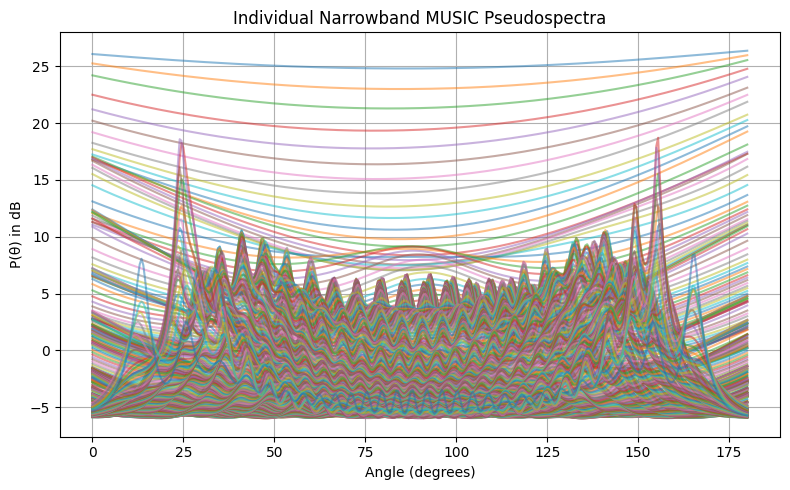

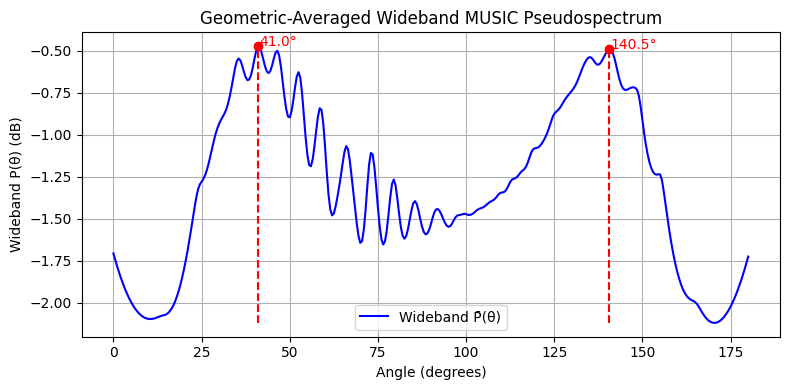

(4, 2)


In [305]:
# Head-mounted 
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def steering_vector_2d(mic_positions, theta_deg, freq, c):
    # M = mic_positions.shape[0]

    theta = np.deg2rad(theta_deg)
    
    k0 = 2.0 * np.pi * freq / c
    
    phase = k0 * (mic_positions[:, 0] * np.cos(theta)
                  + mic_positions[:, 1] * np.sin(theta))        # shape: (M,)
    
    a = np.exp(-1j * phase)
    return a

def music_wideband_HM(stft_mics, Q, c, mic_positions):
    M, nF, nT = stft_mics.shape
    
    theta_vals = np.arange(0, 180.5, 0.5)
    nTheta = len(theta_vals)
    
    freq_bins = range(1, nF-1)  
    nFreqUsed = len(freq_bins)
    
    all_pseudospec = np.zeros((nFreqUsed, nTheta), dtype=float)
    
    for i, fidx in enumerate(freq_bins):
        f_bin = f[fidx]
        
        X_omega = stft_mics[:, fidx, :]  # (M, nT)
        Rxx = (X_omega @ X_omega.conj().T) / nT
        
        eigenvals, eigenvecs = np.linalg.eig(Rxx)
        sort_idx = np.argsort(eigenvals)
        Un = eigenvecs[:, sort_idx[:(M-Q)]]  # (M, M-Q)
        
        # k0 = 2.0 * np.pi * f_bin / c
        # m_index = np.arange(M)
        
        for j, theta_deg in enumerate(theta_vals):
            steer = steering_vector_2d(mic_positions, theta_deg, f_bin, c)
            
            v = Un.conj().T @ steer
            denom = np.abs(v @ v.conj())
            pseudospec = 1.0 / denom
            
            all_pseudospec[i, j] = pseudospec
    
    plt.figure(figsize=(8,5))
    for i in range(nFreqUsed):
        plt.plot(theta_vals, 10*np.log10(all_pseudospec[i, :]), alpha=0.5, label=f"bin {freq_bins[i]}")
    plt.title("Individual Narrowband MUSIC Pseudospectra")
    plt.xlabel("Angle (degrees)")
    plt.ylabel("P(θ) in dB")
    plt.grid(True)
    # plt.legend(loc='best', ncol=2, fontsize='small')
    plt.tight_layout()
    plt.show()
    
    log_all = np.log(all_pseudospec + 1e-15)  # Avoid log(0)
    mean_log = np.mean(log_all, axis=0)      
    p_wideband = np.exp(mean_log)   # shape: (nTheta,)            
    
    peaks, properties = find_peaks(
        p_wideband,
        distance=5,     # 至少分开几个采样点(约2.5°=5*0.5°)
        prominence=0.1  # 视数据情况调整
        # height=0.6*np.max(p_wideband) 
    )

    # if p_wideband[0] > 0.9*np.max(p_wideband):
    #     peaks = np.append(peaks, 0)
    # if p_wideband[-1] > 0.8*np.max(p_wideband):
    #     peaks = np.append(peaks, -1)
    
    if len(peaks) == 0:
        print("Warning: no peak found!")
        doa_estimates = np.array([])
    else:
        peak_vals = p_wideband[peaks]
        if len(peaks) >= Q:
            idx_top = np.argsort(peak_vals)[-Q:]
        else:
            idx_top = np.argsort(peak_vals)  
        idx_top_sorted = idx_top[np.argsort(peak_vals[idx_top])]
        
        peak_indices = peaks[idx_top_sorted]
        doa_estimates = theta_vals[peak_indices]  
    
    plt.figure(figsize=(8,4))
    plt.plot(theta_vals, 10*np.log10(p_wideband), 'b-', label='Wideband P̄(θ)')
    plt.grid(True)
    plt.xlabel("Angle (degrees)")
    plt.ylabel("Wideband P(θ) (dB)")
    plt.title("Geometric-Averaged Wideband MUSIC Pseudospectrum")
    
    for doa in doa_estimates:
        val_db = 10*np.log10(p_wideband[theta_vals==doa])
        plt.plot(doa, val_db, 'ro')
        plt.vlines(doa, min(10*np.log10(p_wideband)), val_db, color='r', linestyles='--')
        plt.text(doa+0.5, val_db, f"{doa:.1f}°", color='red')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return doa_estimates

mic_positions = np.array([
    [0, 0   ],  # L1
    [0, -0.013],  # L2
    [0.215, 0],   # R1
    [0.215, -0.013]  # R2
    # [0, 0.4]
])
c = 340

doa_estimates_wideband = music_wideband_HM(stft_mics, 2, c, mic_positions)

print(mic_positions.shape)



(88201,)
44100


<Figure size 640x480 with 0 Axes>

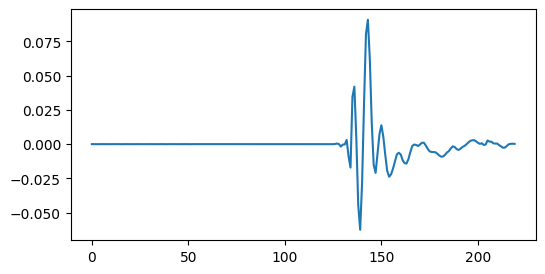

In [228]:
test1, fs_HMIR = sf.read("F:\KU Leuven\courses\PD_ISSP\project\panddissp-base-main\sound_files\head_mounted_rirs\s30\HMIR_L1.wav")
print(test1.shape)
print(fs_HMIR)
T_truncate = int(0.005*fs_HMIR)
sd.play(test1[0:T_truncate], samplerate=fs_HMIR)

plt.figure()
plt.figure(figsize=(6, 3))
plt.plot(test1[0:T_truncate])


# Week 3: DOA-informed Beamforming


In [ ]:
# beamforming
import numpy as np
from scipy.signal import stft
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

def das_bf(mic, acousticScenario):
    c = 340                     # speed of sound
    fs = acousticScenario.fs    # sampling frequency
    L = 1024                    # window length
    hop = L // 2                # 50% overlap
    M = mic.shape[1]            # number of microphones
    if acousticScenario.RIRsNoise is not None:
        Q = acousticScenario.RIRsAudio.shape[-1] + acousticScenario.RIRsNoise.shape[-1] # Number of sources
    else:
        Q = acousticScenario.RIRsAudio.shape[-1]

    stft_mics_list = []

    for m in range(M):
        mic_signal = mic[:, m]
    
        _, _, Zxx = stft(mic_signal,
                     fs = fs,
                     window = 'hann',   # 'hann', 'boxcar'
                     nperseg = L,
                     noverlap = hop,
                     return_onesided = True)

        stft_mics_list.append(Zxx)  # shape: (nF, nT)

    stft_mics = np.array(stft_mics_list)  # (M, nF, nT)


    DOA_est = music_wideband(stft_mics, acousticScenario.RIRsAudio.shape[2], acousticScenario.distBwMics, c)

    doa_deg = DOA_est
    theta_rad = np.deg2rad(doa_deg)

    # N = mic.shape[0]

    def delay_and_sum(signals, fs, dist, c, theta):
        """
        signals: shape (N, M)，N采样点, M麦克风
        fs     : 采样率
        dist   : 麦克风间距
        c      : 声速
        theta  : 入射角(弧度)
        
        返回: shape (N,) 的单通道 DAS 输出
        """
        N, M_ = signals.shape
        output = np.zeros(N)
        
        for m in range(M_):
            # 麦克风 m 的位置(若首个麦克风在坐标0，则 m 距离为 m*dist)
            mic_pos = m * dist
            # end-fire=0° => 用 cos(theta)，broadside=90° => 用 sin(theta)
            # 下面假设 90° 是正对麦克风阵列(即broadside)
            delay_secs = (mic_pos * np.sin(theta)) / c
            delay_samples = int(round(delay_secs * fs))

            # 将 signals[:, m] 做简单整数延时(如果为负, 可以做特殊处理)
            shifted = np.zeros_like(signals[:, m])
            if delay_samples >= 0:
                if delay_samples < N:
                    shifted[delay_samples:] = signals[:-delay_samples, m]
                # 若 delay_samples >= N，则整段被推掉了 => 全零
            else:
                # 负延时（如果需要 end-fire等场景），可处理一下
                # 下面简单示例: 往前移 |delay_samples|:
                dly = -delay_samples
                if dly < N:
                    shifted[:N-dly] = signals[dly:, m]

            output += shifted  # 累加
        return output
    
    speechDAS = delay_and_sum(mic[:,0], fs, acousticScenario.distBwMics, c, theta_rad)
    noiseDAS  = delay_and_sum(mic[:,1], fs, acousticScenario.distBwMics, c, theta_rad)

    DASout = speechDAS + noiseDAS

    p_mic0_speech = np.mean(speech[:, 0]**2)
    p_das_speech  = np.mean(speechDAS**2)
    if p_das_speech > 1e-12:
        alpha = np.sqrt(p_mic0_speech / p_das_speech)
    else:
        alpha = 1.0  # 防止极端情况
    
    # 应用缩放
    speechDAS *= alpha
    noiseDAS  *= alpha
    DASout    *= alpha

    sig_power   = np.mean(speechDAS**2)
    noise_power = np.mean(noiseDAS**2) if np.any(noiseDAS != 0) else 1e-12
    SNRoutDAS   = 10.0 * np.log10(sig_power / noise_power)

    plt.figure(figsize=(8,4))
    plt.plot(speech[:,0], label="Mic0 (speech only)", alpha=0.6)
    plt.plot(DASout, label="DASout (speech + noise)", alpha=0.8)
    plt.title(f"DAS Beamformer Output (DOA = {doa_deg:.1f}°)\nSNRoutDAS = {SNRoutDAS:.2f} dB")
    plt.legend()
    plt.tight_layout()
    plt.show()

    return DASout, speechDAS, noiseDAS, SNRoutDAS
        
DASout, speechDAS, noiseDAS, SNRoutDAS = das_bf(mic, acousticScenario)

In [ ]:
# GSC
import numpy as np
import matplotlib.pyplot as plt

def gsc_td(mic, acousticScenario):
    """
    DOA-informed GSC (Time-Domain) 实现示例:
      1) 调用 das_bf()
      2) 构造阻挡矩阵 B，生成 (M-1) 通道的噪声参考
      3) 多通道 NLMS 自适应滤波, 以最小化 DAS输出中的噪声
      4) 返回 GSC 输出及其 SNR
    
    参数:
    --------
    mic : ndarray, shape (N, M)
        N 个采样点, M 个麦克风
    acousticScenario : object
        包含 fs, distBwMics, 以及在 das_bf 中使用的各种信息
    
    返回:
    --------
    GSCout : ndarray, shape (N,)
        GSC 输出信号(时域)
    SNRoutGSC : float
        GSC 输出的估计 SNR (dB)
    """

    # 1) 先运行 DAS 波束形成 (你已经写好的函数)
    DASout, speechDAS, noiseDAS, SNRoutDAS = das_bf(mic, acousticScenario)
    N = len(DASout)
    
    # -------------------------------------------------------------------------
    # 2) 构造 Griffiths-Jim 阻挡矩阵 B (shape=(M-1, M))
    #
    #   对线阵来说, 常见的简单形式:
    #       B = [  1  -1   0   0  ...   0
    #              0   1  -1   0  ...   0
    #               ...                  ...
    #              0   0   0   0  ...  -1 ]
    #
    #   当 B * [x1(t), x2(t), ..., xM(t)]^T 时, 理想情况下, 目标源相同相位被消除, 仅剩噪声参考
    # -------------------------------------------------------------------------
    M = mic.shape[1]
    # Griffiths–Jim blocking matrix:
    B = np.zeros((M-1, M))
    for i in range(M-1):
        B[i, i]   =  1.0
        B[i, i+1] = -1.0
    # B.shape => (M-1, M)
    
    # 需要一个"对齐后的麦克风信号" X_delay(t) 与 DAS 相同延时策略
    # 但为演示简化，假设 mic 已经是对齐后的(或忽略延时).
    # 这里直接将 mic(t) 乘以 B^T:
    X_block = mic @ B.T   # shape => (N, M-1)
    
    # -------------------------------------------------------------------------
    # 3) 多通道自适应滤波 (NLMS)
    #
    #   GSC 原理: GSCout(t) = DASout(t) - sum( W_i * X_block_i(t) )
    #   其中 X_block_i(t) 是阻挡矩阵输出的第 i 通道, W_i(t) 是长度 L=1024 的FIR滤波器
    #   => 令 Z(t) = [ X_block_1(t), ..., X_block_{M-1}(t) ]^T
    #
    #   这里示例: NLMS + 每个通道独立滤波器(长度 L taps)
    #   stepSize mu=0.1, 每帧更新(最简单的逐点实现)
    #
    #   delta = L/2 题目里提到是为了因果实现(延迟主路),
    #   但此处示例仅做简单的time-domain NLMS, 并未实现额外延迟
    # -------------------------------------------------------------------------
    L = 1024          # FIR 长度
    mu = 0.1          # 步长
    # 初始化多通道滤波器, shape => (M-1, L)
    W = np.zeros((M-1, L))
    
    # 为方便处理, 建立延迟线缓冲, shape => (M-1, L)
    z_buf = np.zeros((M-1, L))
    
    # 自适应滤波输出(与 DASout 等长)
    adapt_out = np.zeros(N)  
    
    eps = 1e-8  # 防止除0
    
    for n in range(N):
        # 把新采样塞进 z_buf => z_buf[:, 1:] 往前移 => z_buf[:, 0] = X_block[:, n]
        z_buf = np.roll(z_buf, 1, axis=1)  
        # 更新最前面(第0列)为当前采样
        for c in range(M-1):
            z_buf[c, 0] = X_block[n, c]
        
        # 计算当前滤波器输出(对(M-1)通道做点积再求和)
        y_n = 0.0
        for c in range(M-1):
            # W[c, :] · z_buf[c, :]
            y_n += np.dot(W[c, :], z_buf[c, :])
        
        adapt_out[n] = y_n
        
        # 更新滤波器权值 (NLMS)
        # e(n) = DASout(n) - y(n)
        e_n = DASout[n] - y_n
        power_z = 0.0
        for c in range(M-1):
            power_z += np.dot(z_buf[c, :], z_buf[c, :])
        for c in range(M-1):
            # NLMS update:
            W[c, :] += mu * e_n * z_buf[c, :] / (power_z + eps)
    
    GSCout = DASout - adapt_out
    
    # -------------------------------------------------------------------------
    # 4) 估计 GSC 输出的 SNR, 假设 noiseDAS(仅噪声段) ~ stationarity
    #
    #   这里为了简单, 直接假设在纯噪声段, speechDAS=0 => 计算噪声功率
    #   或者你可以根据实际VAD / segments 做分段统计
    # -------------------------------------------------------------------------
    speech_power = np.mean((speechDAS)**2)
    noise_power  = np.mean((noiseDAS)**2) if np.any(noiseDAS!=0) else 1e-12
    SNRoutGSC    = 10.0 * np.log10( speech_power / noise_power )
    
    # -------------------------------------------------------------------------
    # 5) 画图对比 GSC 输出 vs. DAS 输出 vs. speechDAS
    # -------------------------------------------------------------------------
    plt.figure(figsize=(8,5))
    plt.plot(DASout, label='DASout')
    plt.plot(GSCout, label='GSCout')
    plt.plot(speechDAS, label='DAS-speech-only', alpha=0.7)
    plt.title(f"GSC Output (mu={mu}, L={L}), SNRoutGSC={SNRoutGSC:.2f} dB")
    plt.xlabel("Sample Index")
    plt.ylabel("Amplitude")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    return GSCout, SNRoutGSC
